# Linear Regression

The idea is to explore a classifier named Logistic Regression.
However, to introduce the inner workings of such a model, let us start to analyse the Linear Regression one.

This will allow us to understant:
1. what is a linear model
2. define a cost function to train a model
3. how to fit a linear model given a cost function
4. Traditional optimization methods 

The linear regression models is defined by:
$$
h(x,m,b) = m\times x + b
$$

The tipical cost function to compute fit the linear regression is the following:
$$
e = \frac{\sum_{i=0}^{n}(y_i-h(x_i, m, b))^2}{2n}
$$

In [1]:
import os
import math
import nltk
import tqdm
import joblib
import numpy as np
import polars as pl
import seaborn as sns

import jax
import jax.numpy as jnp
import pyBlindOpt.pso as pso

from sklearn.datasets import make_regression

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,10]
plt.rcParams['figure.dpi'] = 72

In [2]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [3]:
x, y = make_regression(n_samples=1000, n_features=1, noise=7, random_state=42)

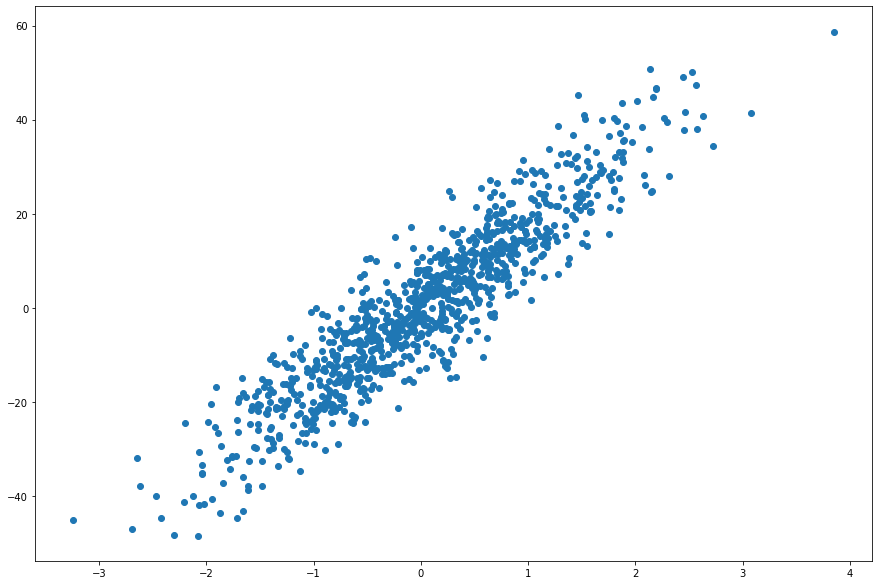

In [4]:
# plot the data
plt.plot(x, y, 'o')
plt.show()

In [5]:
class LRPSO:
    def fit(self, X, y, iter=300):
        def _f(w):
            wt = w[np.newaxis].T
            y_hat = wt[0] + np.dot(X, wt[1:])
            return y_hat

        def _cost(w):
            y_hat = _f(w)
            return np.mean(np.power((y-y_hat.flatten()), 2))

        bounds = np.asarray([(-50.0, 50.0), (-50.0, 50.0)])
        solution = pso.particle_swarm_optimization(_cost, bounds, n_iter=iter, verbose=True)
        self.w = solution[0]
    
    def predict(self, X):
        wt = self.w[np.newaxis].T
        y_hat = wt[0] + np.dot(X, wt[1:]) 
        return y_hat.flatten()
    
    def params(self):
        return self.w

In [6]:
lr = LRPSO()
lr.fit(x, y)
print(f'LR {lr.params()}')

100%|██████████| 300/300 [00:07<00:00, 40.28it/s]

LR [ 0.03168348 16.66795968]


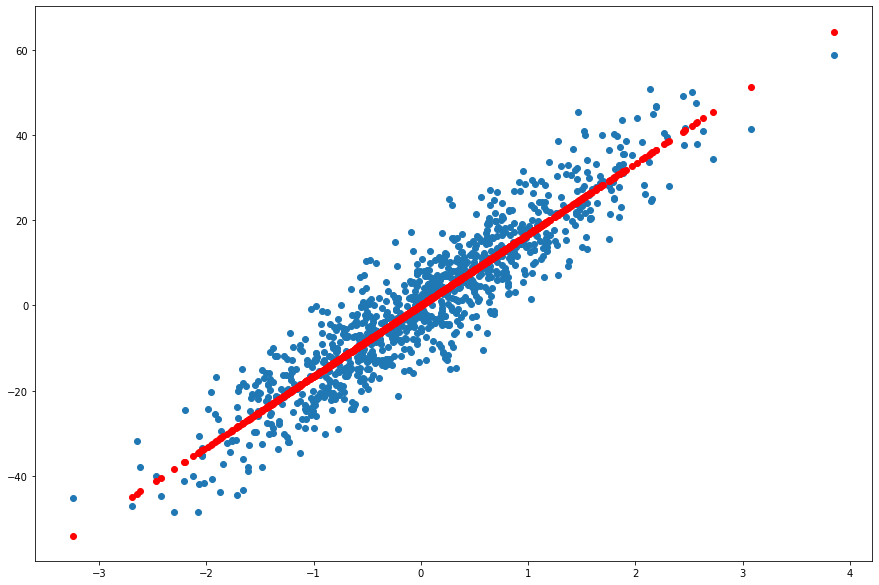

In [7]:
y_hat = lr.predict(x)
# plot the data
plt.plot(x, y, 'o')
plt.plot(x, y_hat, 'ro')
plt.show()

In [8]:
cost = rmse(y, y_hat)
print(f'RMSE = {cost}')

RMSE = 6.930285482801353


In [9]:
class LR:
    def fit(self, X, y, lr=0.01, iter=1000):
        def _f(w):
            wt = w[np.newaxis].T
            y_hat = wt[0] + np.dot(X, wt[1:])
            return y_hat

        nd = 2 if len(X.shape) == 1 else (X.shape[1] + 1)
        self.w = np.array([1.0]*nd)
        for _ in tqdm.tqdm(range(iter)):
            y_hat = _f(self.w)                          # The current predicted value of Y
            diff = y - y_hat.flatten()                            
            D_m = []
            for i in range(X.shape[1]):
                D_m.append(np.average(-X[:,i] * diff))  # Derivative wrt m
            D_m = np.array(D_m)
            D_c = - np.average(diff)                    # Derivative wrt c
            self.w[1:] = self.w[1:] - lr * D_m          # Update m
            self.w[0] = self.w[0] - lr * D_c            # Update c

    
    def predict(self, X):
        wt = self.w[np.newaxis].T
        y_hat = wt[0] + np.dot(X, wt[1:]) 
        return y_hat.flatten()
    
    def params(self):
        return self.w

In [10]:
lr = LR()
lr.fit(x,y)
print(f'LR {lr.params()}')

100%|██████████| 1000/1000 [00:00<00:00, 25139.08it/s]

LR [ 0.03189144 16.66690146]


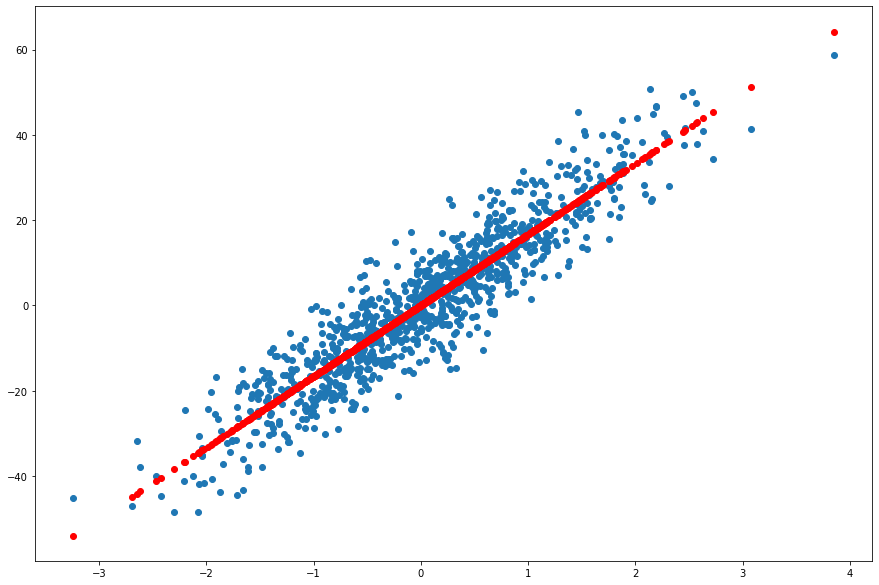

In [11]:
y_hat = lr.predict(x)
# plot the data
plt.plot(x, y, 'o')
plt.plot(x, y_hat, 'ro')
plt.show()

In [12]:
cost = rmse(y,y_hat)
print(f'RMSE = {cost}')

RMSE = 6.930285562733726


In [13]:
class LRAG:
    def fit(self, X, y, lr=0.01, iter=300):
        def _J(w):
            wt = w[jnp.newaxis].T
            y_hat = wt[0] + jnp.dot(X, wt[1:])
            return jnp.mean((y-y_hat.flatten())**2.0)+1E-5*(jnp.sum(w))**2
            
            
        g = jax.grad(_J)
        nd = 2 if len(X.shape) == 1 else (X.shape[1] + 1)
        w = np.array([1.0]*nd)

        for _ in tqdm.tqdm(range(iter)):
            w = w - lr * g(w)
        
        self.w = w

    def predict(self, X):
        wt = self.w[np.newaxis].T
        y_hat = wt[0] + np.dot(X, wt[1:]) 
        return y_hat.flatten()
    
    def params(self):
        return self.w

In [14]:
lr = LRAG()
lr.fit(x,y)
print(f'LR {lr.params()}')

100%|██████████| 300/300 [00:02<00:00, 103.55it/s]

LR [ 0.03873518 16.620008  ]


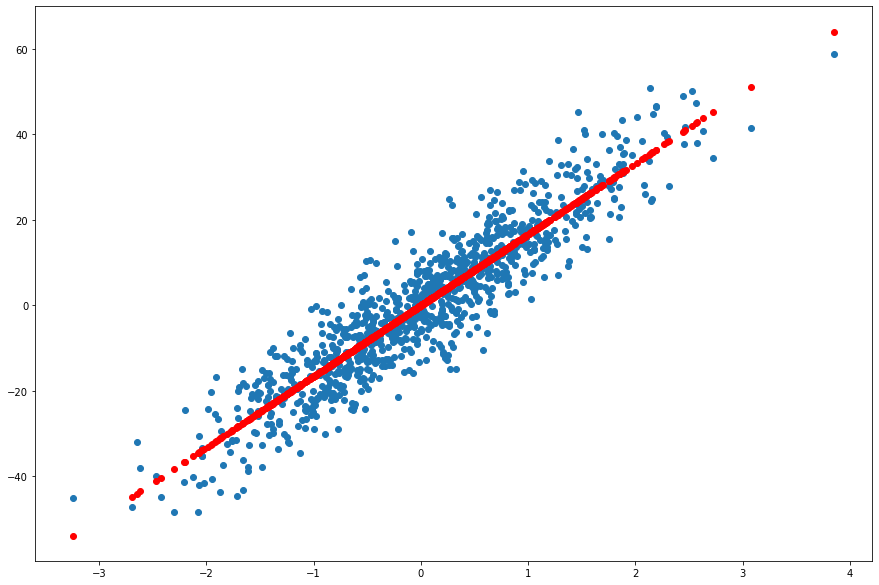

In [15]:
y_hat = lr.predict(x)
# plot the data
plt.plot(x, y, 'o')
plt.plot(x, y_hat, 'ro')
plt.show()

In [16]:
cost = rmse(y,y_hat)
print(f'RMSE = {cost}')

RMSE = 6.930447578430176


In [17]:
class LRAGNewton:
    def fit(self, X, y, maxiter=100, tol=1e-5):
        def _J(w):
            wt = w[jnp.newaxis].T
            y_hat = wt[0] + jnp.dot(X, wt[1:])
            return jnp.mean((y-y_hat.flatten())**2.0)+1E-5*(jnp.sum(w))**2
        
        g = jax.grad(_J)
        h = jax.hessian(_J)
        nd = 2 if len(X.shape) == 1 else (X.shape[1] + 1)
        w = np.array([1.0]*nd)

        for _ in tqdm.tqdm(range(maxiter)):
            delta = np.linalg.solve(h(w), -g(w))
            w = w + delta
            if np.linalg.norm(delta) < tol:
                break
        
        self.w = w

    def predict(self, X):
        wt = self.w[np.newaxis].T
        y_hat = wt[0] + np.dot(X, wt[1:]) 
        return y_hat.flatten()
        

    def params(self):
        return self.w

In [18]:
lr = LRAGNewton()
lr.fit(x,y)
print(f'LR {lr.params()}')

  1%|          | 1/100 [00:00<01:23,  1.19it/s]

LR [ 0.03151984 16.66778977]


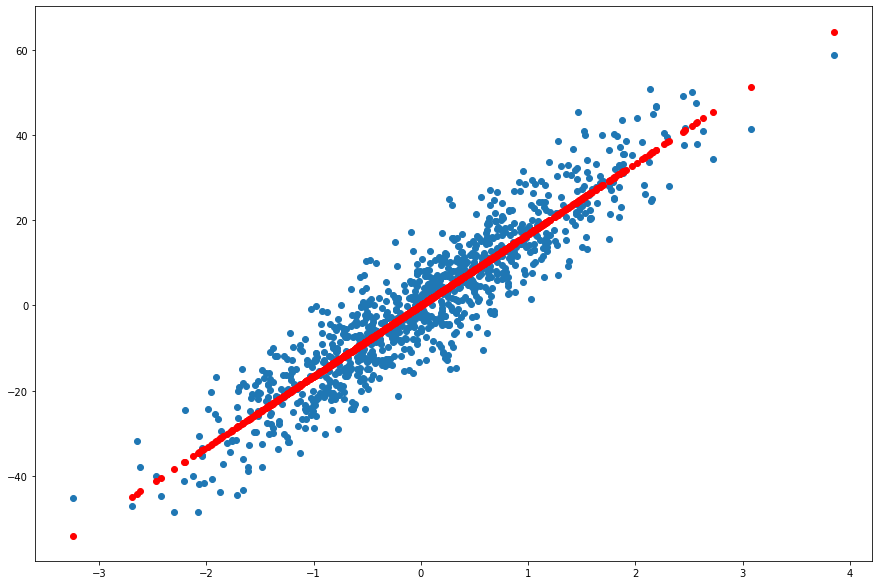

In [19]:
y_hat = lr.predict(x)
# plot the data
plt.plot(x, y, 'o')
plt.plot(x, y_hat, 'ro')
plt.show()

In [20]:
cost = rmse(y,y_hat)
print(f'RMSE = {cost}')

RMSE = 6.9302854868065165


## Non Linear Data

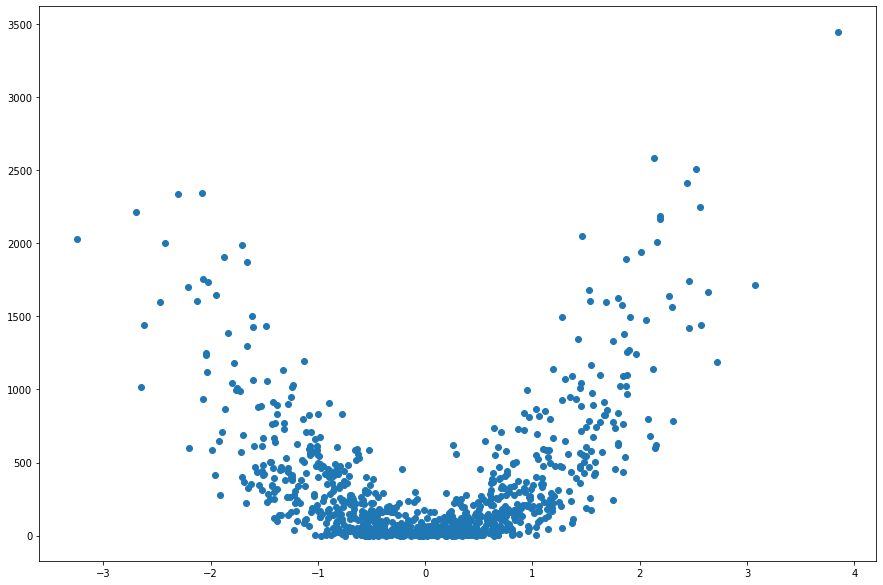

In [21]:
x, y = make_regression(n_samples=1000, n_features=1, noise=7, random_state=42)
x = x[:,0]
y = np.square(y)

# plot the data
plt.plot(x, y, 'o')
plt.show()

In [22]:
x_squared = np.square(x)
X = np.column_stack((x, x_squared))

In [23]:
lr = LRAGNewton()
lr.fit(X,y)
print(f'LR {lr.params()}')

  2%|▏         | 2/100 [00:00<00:46,  2.11it/s]

LR [ 59.20556205   8.89410104 265.99701315]


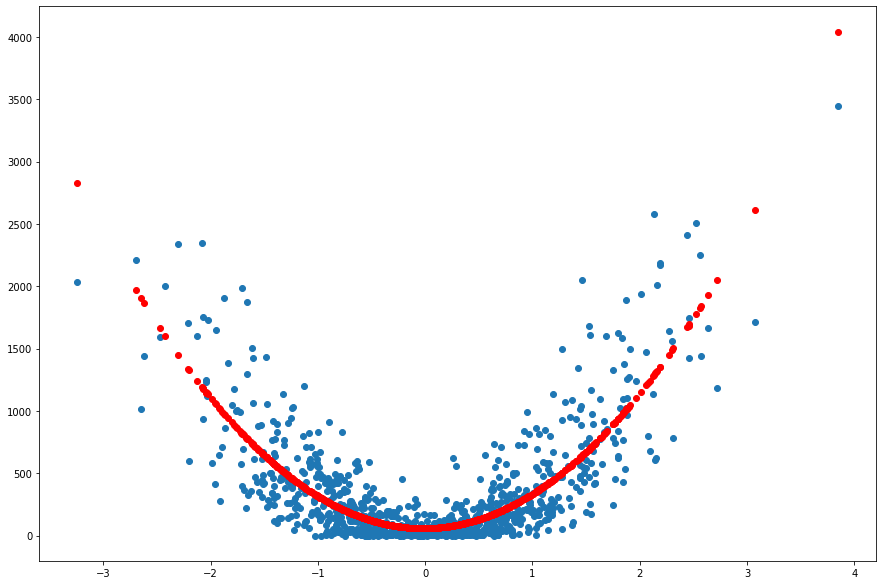

In [24]:
y_hat = lr.predict(X)

# plot the data
plt.plot(x, y, 'o')
plt.plot(x, y_hat, 'ro')
plt.show()